# Track TSMC with random forest

### Libraries

In [4]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # or RandomForestRegressor etc.
from sklearn.metrics import accuracy_score  # or mean_squared_error for regression
from datetime import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  # SVM Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Functions

In [7]:
def fetch_data(ticker, timespan = '10y'):
    data_temp = yf.download(ticker, period = timespan) #get data through API
    data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
    data_temp = data_temp.ffill() # remove rows with NaN
    return data_temp

In [9]:
def fetch_data_span(ticker, start_time = "2015-02-24", end_time = "2023-02-24"):
    data_temp = yf.download(ticker, start = start_time, end = end_time)
    data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
    data_temp = data_temp.ffill() # remove rows with NaN
    return data_temp

In [11]:
def get_pct_diff_lastnight(data, open_ticker, close_ticker):
    prev_Close = data[close_ticker].shift(1)  # yesterday's close
    return (data[open_ticker] - prev_Close) / prev_Close * 100  # today's open minus yesterday's close

In [13]:
def get_pct_change_lastday(data, ticker):
    pct_change = data[ticker].pct_change() * 100
    return pct_change.shift(1)

In [15]:
def get_data_lastday(data, ticker):
    return data[ticker].shift(1)

In [17]:
# def get_volume_lastday(data, ticker):
#     df_temp = pd.DataFrame()
#     df_temp['vol_lastday'] = data[ticker].shift(1)
#     scaler = StandardScaler()
#     return scaler.fit_transform(df_temp[['vol_lastday']]) #scaled vol

In [19]:
# from GPT
def get_volume_lastday(data, ticker):
    vol_lastday = data[ticker].shift(1)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(vol_lastday.values.reshape(-1, 1))
    return pd.Series(scaled.flatten(), index=vol_lastday.index)

In [21]:
def get_diff_to_avg_lastday(data, ticker, timespan = 5):
    avg = data[ticker].rolling(timespan).mean()
    diff_to_avg = data[ticker] - avg
    return diff_to_avg.shift(1)

In [23]:
def get_diff_to_avg(data, ticker, timespan = 5):
    avg = data[ticker].rolling(timespan).mean()
    diff_to_avg = data[ticker] - avg
    return diff_to_avg

In [25]:
def get_diff_label(data, openticker, closeticker, threshold = 0.004):
    df_temp = pd.DataFrame()
    df_temp['diff'] = (data[closeticker] - data[openticker]) / data[openticker]
    conditions = [
    df_temp['diff'] > threshold,
    df_temp['diff'].between(- threshold, threshold),
    df_temp['diff'] < - threshold
    ]
    choices = [1, 0, -1]
    return pd.Series(np.select(conditions, choices), index=data.index)

## Introduce Data from: 2330, S&P500, VIX, SOX, TSM

In [30]:
# fetch data
data = pd.DataFrame()
data = fetch_data_span(ticker = ['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'])
# print(data.head(), '\n\n============================')

# data manipulation to get features
df = pd.DataFrame()
df['2330_diff_lastnight'] = get_pct_diff_lastnight(data, 'Open_2330.TW', 'Close_2330.TW')

# Add MA information as features
df['2330_diff_to_5d_avg'] = get_diff_to_avg(data, 'Open_2330.TW', timespan = 5) 
df['2330_diff_to_10d_avg'] = get_diff_to_avg(data, 'Open_2330.TW', timespan = 10) 
df['2330_diff_to_20d_avg'] = get_diff_to_avg(data, 'Open_2330.TW', timespan = 20) 
df['2330_diff_to_60d_avg'] = get_diff_to_avg(data, 'Open_2330.TW', timespan = 60) 
df['2330_diff_to_120d_avg'] = get_diff_to_avg(data, 'Open_2330.TW', timespan = 120) 
df['2330_diff_to_240d_avg'] = get_diff_to_avg(data, 'Open_2330.TW', timespan = 240) 

df['SP500_change_lastday'] = get_pct_change_lastday(data, 'Close_^GSPC')
df['SP500_vol_lastday'] = get_volume_lastday(data, 'Volume_^GSPC')
df['SP500_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_^GSPC')

df['TSM_change_lastday'] = get_pct_change_lastday(data, 'Close_TSM')
df['TSM_vol_lastday'] = get_volume_lastday(data, 'Volume_TSM')
df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_TSM')

df['VIX_change_lastday'] = get_pct_change_lastday(data, 'Close_^VIX')
df['VIX_lastday'] = get_data_lastday(data, 'Close_^VIX')

df['SOX_change_lastday'] = get_pct_change_lastday(data, 'Close_^SOX')
df['SOX_lastday'] = get_data_lastday(data, 'Close_^SOX')

# df = df.dropna()
# print(df.head(10))


[*********************100%***********************]  5 of 5 completed


In [32]:
#get label
df['label'] = get_diff_label(data, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')
# print(df.head())

## Assign Labels Features
### (S&P lastnight, vol; 2330 diff overnight; VIX lastnight; TSM lasnight changes, vol; SOX lastnight changes

In [35]:
# Clean the df
df_clean = df.dropna()

# Split your dataset first
X = df_clean.drop(columns = ['label'], axis=1)  # features
y = df_clean['label']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features (recommended for SVM and others)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Check correlation between features

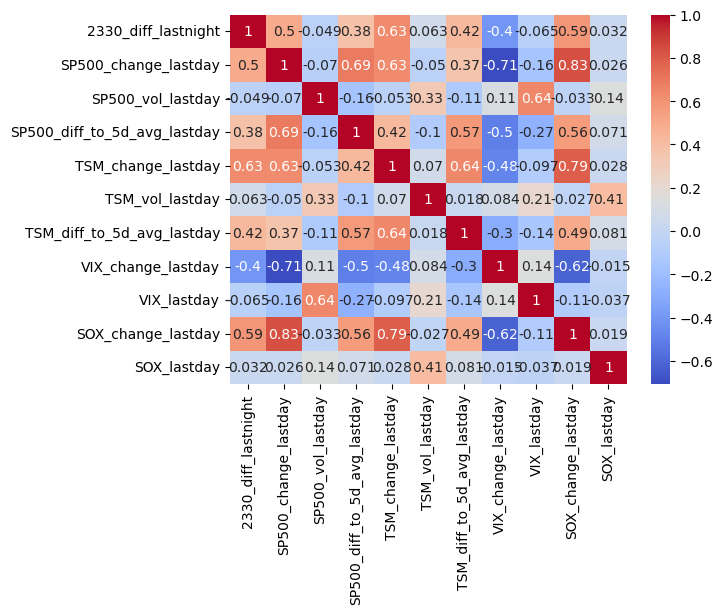

In [125]:
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## Train the Model with SVM/Random Forest

In [31]:
model = SVC(kernel='rbf', C=10, gamma='auto')  # Common setup
model.fit(X_train, y_train)

SVC(C=10, gamma='auto')

In [37]:
# Using Random Forest
model = RandomForestClassifier(
    n_estimators=1000,  # number of trees
    max_depth=None,    # grow trees until all leaves are pure
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

## Evaluate the Result

In [40]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.42


In [42]:
print(y_train.value_counts(normalize=True))

label
 0    0.349217
 1    0.328114
-1    0.322668
Name: proportion, dtype: float64


In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.39      0.32      0.35       118
           0       0.45      0.60      0.52       129
           1       0.40      0.33      0.36       121

    accuracy                           0.42       368
   macro avg       0.41      0.42      0.41       368
weighted avg       0.41      0.42      0.41       368



# Test run on seperate data

## Load test run data into df

In [53]:
test_run_data = pd.DataFrame()
test_run_data = fetch_data_span(ticker = ['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'], start_time = "2023-02-25", end_time = "2025-02-25")

test_run_df = pd.DataFrame()
test_run_df['2330_diff_lastnight'] = get_pct_diff_lastnight(test_run_data, 'Open_2330.TW', 'Close_2330.TW')

# Add MA information as features
test_run_df['2330_diff_to_5d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 5) 
test_run_df['2330_diff_to_10d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 10) 
test_run_df['2330_diff_to_20d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 20) 
test_run_df['2330_diff_to_60d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 60) 
test_run_df['2330_diff_to_120d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 120) 
test_run_df['2330_diff_to_240d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 240) 

test_run_df['SP500_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^GSPC')
test_run_df['SP500_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_^GSPC')
test_run_df['SP500_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_^GSPC')

test_run_df['TSM_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_TSM')
test_run_df['TSM_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_TSM')
test_run_df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_TSM')

test_run_df['VIX_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^VIX')
test_run_df['VIX_lastday'] = get_data_lastday(test_run_data, 'Close_^VIX')

test_run_df['SOX_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^SOX')
test_run_df['SOX_lastday'] = get_data_lastday(test_run_data, 'Close_^SOX')

test_run_df['label'] = get_diff_label(test_run_data, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')

test_run_df_clean = test_run_df.dropna()

# print(test_run_df_clean.head())

# print("X_test_run:", len(X_test_run), "y_test_run_pred:", len(y_test_run_pred))



[*********************100%***********************]  5 of 5 completed


## Compare the actual diff with pred

In [55]:
X_test_run = test_run_df_clean.drop(columns = ['label'])
y_test_run_pred = model.predict(X_test_run)
y_test_run = test_run_df_clean['label']

test_run_accuracy = accuracy_score(y_test_run, y_test_run_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.42


In [49]:
print(y_test_run.value_counts(normalize=True))

label
-1    0.388489
 1    0.377698
 0    0.233813
Name: proportion, dtype: float64


In [51]:
print(classification_report(y_test_run, y_test_run_pred))

              precision    recall  f1-score   support

          -1       0.41      0.61      0.49       108
           0       0.28      0.28      0.28        65
           1       0.44      0.23      0.30       105

    accuracy                           0.39       278
   macro avg       0.38      0.37      0.36       278
weighted avg       0.39      0.39      0.37       278



## Use test run data to trade and see the return/loss

In [95]:
test_run_data = pd.DataFrame()
test_run_data = fetch_data_span(ticker = ['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'], start_time = "2023-02-25", end_time = "2025-02-25")

test_run_df = pd.DataFrame()
test_run_df['2330_diff'] = test_run_data['Close_2330.TW'] - test_run_data['Open_2330.TW'] # Use this column to book the return or loss
test_run_df['2330_open'] = test_run_data['Open_2330.TW']
test_run_df['2330_diff_lastnight'] = get_pct_diff_lastnight(test_run_data, 'Open_2330.TW', 'Close_2330.TW')

# Add MA information as features
test_run_df['2330_diff_to_5d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 5) 
test_run_df['2330_diff_to_10d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 10) 
test_run_df['2330_diff_to_20d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 20) 
test_run_df['2330_diff_to_60d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 60) 
test_run_df['2330_diff_to_120d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 120) 
test_run_df['2330_diff_to_240d_avg'] = get_diff_to_avg(test_run_data, 'Open_2330.TW', timespan = 240) 

test_run_df['SP500_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^GSPC')
test_run_df['SP500_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_^GSPC')
test_run_df['SP500_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_^GSPC')

test_run_df['TSM_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_TSM')
test_run_df['TSM_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_TSM')
test_run_df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_TSM')

test_run_df['VIX_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^VIX')
test_run_df['VIX_lastday'] = get_data_lastday(test_run_data, 'Close_^VIX')

test_run_df['SOX_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_^SOX')
test_run_df['SOX_lastday'] = get_data_lastday(test_run_data, 'Close_^SOX')

test_run_df['label'] = get_diff_label(test_run_data, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')

test_run_df_clean = test_run_df.dropna()

print(test_run_df_clean.head())

# print("X_test_run:", len(X_test_run), "y_test_run_pred:", len(y_test_run_pred))



[*********************100%***********************]  5 of 5 completed

            2330_diff   2330_open  2330_diff_lastnight  2330_diff_to_5d_avg  \
Date                                                                          
2024-01-31  -5.898856  623.312492            -1.246103            -6.095487   
2024-02-01   2.949428  614.464207            -0.477707           -12.977490   
2024-02-02   1.966286  622.329430             0.796191            -2.949357   
2024-02-05   0.983143  634.127087             1.574794             9.044921   
2024-02-06   0.983143  634.127087            -0.154799             8.455026   

            2330_diff_to_10d_avg  2330_diff_to_20d_avg  2330_diff_to_60d_avg  \
Date                                                                           
2024-01-31              3.735945             26.938094             47.558767   
2024-02-01             -8.946600             15.877738             37.434697   
2024-02-02             -1.867896             21.039311             43.909348   
2024-02-05              8.749991             2

In [135]:
# trade_df = pd.DataFrame()
# X_test_run = test_run_df_clean.drop(columns = ['label', '2330_diff', '2330_open'], axis = 1)

# y_test_run_pred = model.predict(X_test_run)
# actual_diff = test_run_df_clean['2330_diff']
# trade_return = y_test_run_pred * actual_diff

# trade_cost = np.absolute(y_test_run_pred) * test_run_df_clean['2330_open']
# # print(trade_cost.head(30))
# print('Total Cost:', trade_cost.sum())
# print(trade_return.head(50))
# print('Total Return:', trade_return.sum())


In [133]:
# trade_df = pd.DataFrame()
trade_df = pd.DataFrame(index=test_run_df_clean.index)
X_test_run = test_run_df_clean.drop(columns = ['label', '2330_diff', '2330_open'], axis = 1)
trade_df['pred'] = model.predict(X_test_run)
trade_df['true_diff'] = test_run_df_clean['2330_diff']
trade_df['cost'] = test_run_df_clean['2330_open']

print(trade_df.head())

initial_capital = 1000
capital = initial_capital
capital_list = [capital]

for i in range(len(trade_df)):
    pred = trade_df['pred'].iloc[i]
    actual_diff = trade_df['true_diff'].iloc[i]
    cost = trade_df['cost'].iloc[i]

    if pred == 0:
        capital_list.append(capital)
        continue

    daily_return = pred * actual_diff / cost
    capital *= (1 + daily_return)
    capital_list.append(capital)
    
trade_df['capital'] = capital_list[:-1]

final_ROE = (capital_list[-1] - initial_capital) / initial_capital
print(f"Final capital: {capital_list[-1]:.2f}, ROI: {final_ROE:.2%}")



            pred  true_diff        cost
Date                                   
2024-01-31    -1  -5.898856  623.312492
2024-02-01     0   2.949428  614.464207
2024-02-02     0   1.966286  622.329430
2024-02-05     0   0.983143  634.127087
2024-02-06     0   0.983143  634.127087
Final capital: 1044.56, ROI: 4.46%


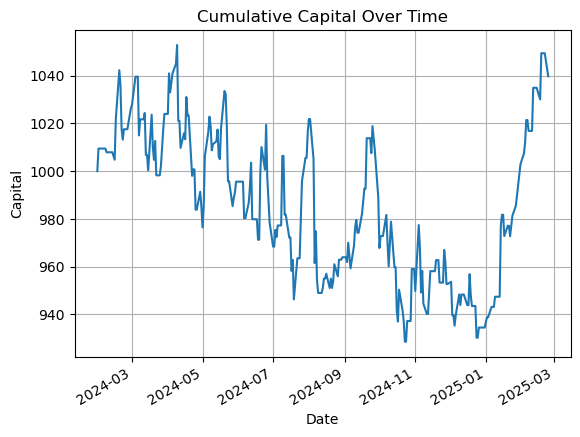

In [137]:
trade_df['capital'].plot(title='Cumulative Capital Over Time')
plt.ylabel('Capital')
plt.xlabel('Date')
plt.grid(True)
plt.show()

## Feature Importance

In [42]:
importances = model.feature_importances_
print(type(importances))
print(importances)

<class 'numpy.ndarray'>
[0.10613121 0.08061175 0.08988171 0.08947451 0.08496977 0.0912021
 0.08975924 0.08622937 0.09427124 0.08389085 0.10357827]


## Try finding Best-performing Hyper-perimeter

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'linear'],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

## Potential Idea for features

instead of 2330, use different stocks/ indexs

instead of indexes, use higher/ more direct related stocks
